In [85]:
import numpy as np
import matplotlib.pyplot as plt

from aeons.tools import pickle_in
samples_g_1, samples_c_1, samples_w_1 = pickle_in("../test_samples/samples_1.pickle")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

from aeons.lm_partial import analytic_lm_params, X_end_formula, analytic_lm, params_from_d
from aeons.covariance import X_mu, X_Sigmainv, logX_mu, points_at_iteration
from aeons.true_distribution import generate_Xs, nk_dead, nk_dead_live, nk_live
from aeons.likelihoods import likelihood, linear_like, quad_like, log_like, simple_like, middle_like, full_like
linear, quad, log = linear_like(), quad_like(), log_like()
simple, middle, full = simple_like(), middle_like(), full_like()
from aeons.models import LS, CG

In [2]:
format = {
    # Use LaTeX to write all text
    "text.usetex": True,
    "font.family": "serif",
    # Use 11pt font in plots, to match 11pt font in document
    "axes.labelsize": 11,
    "font.size": 11,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'axes.linewidth': 0.5,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'patch.linewidth': 0.5,
    'legend.fancybox': False,
    'legend.shadow': False
}
plt.rcParams.update(format)

When nk large, enough points so that least squares fit pretty much balances out with stochastic mean on each side.

So mean vs least squares become basically equivalent for high nk

Much better for low nk

In [3]:
def plot_points(L, X, ndead):
    plt.plot(X[:ndead], L[:ndead], 'x', ms=1)
    plt.plot(X[ndead:], L[ndead:], 'x', ms=1)

def Z(L, X):
    return -np.trapz(L, X)

#### **Endpoint prediction for global gaussian**

In [5]:
samples = samples_g_1
nlive = 500
epsilon = 1e-3
X_end_true = X_end_formula(10, 0.1, epsilon)
endpoint_true = np.log(X_end_true) * (-nlive)
endpoint_true

10840.18928167041

##### Smoothed using live points only

In [6]:
iterations = np.arange(500, 10800, 200)
endpoint_predictions = []
for i, iteration in enumerate(iterations):
    points = points_at_iteration(samples, iteration)
    logL = np.array(points.logL)[iteration:]
    logX_mean = np.array(points.logX())[iteration:]
    X_mean = np.exp(logX_mean)
    _, d, sigma = analytic_lm_params(logL, np.exp(logX_mean), 10)
    X_end = X_end_formula(d, sigma, 0.001)
    logX_end = np.log(X_end)
    endpoint = logX_end * (-nlive)
    endpoint_predictions.append(endpoint)

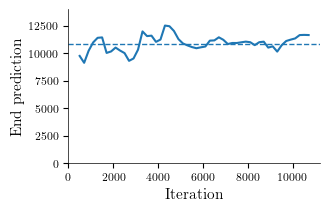

In [7]:
plt.figure(figsize=(3.25,2))
plt.plot(iterations, endpoint_predictions)
plt.axhline(y=endpoint_true, ls='--', lw=1)
plt.ylim(0, 14000)
plt.xlabel('Iteration')
plt.ylabel('End prediction')
plt.savefig('../../../report/figures/endpoints_live.pdf', format='pdf', bbox_inches='tight')

##### Smoothed using bandwith selection

In [8]:
iterations = np.arange(200, 10800, 400)
alphas = np.arange(0, 1, 0.05)
endpoint_predictions = []
for i, iteration in enumerate(iterations):
    points = points_at_iteration(samples, iteration)
    logL = np.array(points.logL)
    X_mean = np.exp(np.array(points.logX()))
    theta_best = None
    logZi = -np.inf
    alpha_best = 0
    for alpha in alphas:
        startf = int(iteration * (1 - alpha))
        logLf = logL[startf:]
        X_meanf = X_mean[startf:]
        lsf = LS(logLf, full, X_meanf)
        thetaf = analytic_lm_params(logLf, X_meanf, 10)
        penalty = startf * np.log(startf) - startf if startf != 0 else 0
        logZf = lsf.logZ(thetaf) - penalty
        if logZf > logZi:
            theta_best = thetaf
            alpha_best = alpha
    print(iteration, alpha_best, theta_best)
    _, d, sigma = theta_best
    X_end = X_end_formula(d, sigma, 0.001)
    logX_end = np.log(X_end)
    endpoint = logX_end * (-nlive)
    endpoint_predictions.append(endpoint)

200 0.9500000000000001 [0.20627071485496629, 9.363551619929876, 0.09989374870752736]
600 0.9500000000000001 [-1.7667675265540197, 9.046216844351676, 0.10199683028501598]
1000 0.9500000000000001 [-1.8728714326113263, 9.193239022524905, 0.10225663850013528]
1400 0.9500000000000001 [-0.3398675469844932, 9.630074151446856, 0.10076579271912572]
1800 0.9500000000000001 [-0.26103783541896064, 9.710513411013906, 0.1007596452504444]
2200 0.9500000000000001 [0.33343650526058966, 9.921870490706326, 0.10024967013891514]
2600 0.9500000000000001 [0.17748906972569856, 9.869441035546489, 0.10039676441235902]
3000 0.9500000000000001 [-0.2898680635769715, 9.714737616116873, 0.10082294249304466]
3400 0.9500000000000001 [-0.36090711674907894, 9.696609173812869, 0.10090181257407552]
3800 0.9500000000000001 [-0.22219031744402784, 9.75522782012064, 0.10080398958516014]
4200 0.9500000000000001 [-0.5119120053320145, 9.645056231333731, 0.10104313537087382]
4600 0.9500000000000001 [-0.5373533708248743, 9.6422425

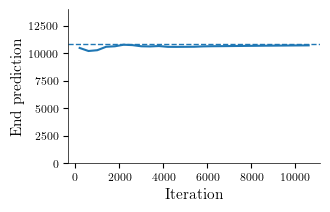

In [9]:
plt.figure(figsize=(3.25,2))
plt.plot(iterations, endpoint_predictions)
plt.axhline(y=endpoint_true, ls='--', lw=1)
plt.ylim(0, 14000)
plt.xlabel('Iteration')
plt.ylabel('End prediction');
plt.savefig('../../../report/figures/endpoints_bandwidth.pdf', format='pdf', bbox_inches='tight')